In [1]:
import torch
import torchvision

In [15]:
import torch
import pytorch_lightning as pl
import lpips


def selu_init(m):
    """
    LeCun Normal initialization for selu.
    """
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="linear")
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="linear")
        if m.bias is not None:
           torch.nn.init.zeros_(m.bias)
    if isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="linear")
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


class CVAE_v3(pl.LightningModule):
    def __init__(self, data, num_domains, num_contents, latent_size, lr, depth, out_channels, kernel_size, activation, downsampling, upsampling, dropout, batch_norm, loss_mode, lamb, no_bn_last=True, initialize=False, max_lamb=1.0):
        super().__init__()

        self.data = "RMNIST"
        self.num_domains = num_domains
        self.num_contents = num_contents
        self.latent_size = latent_size
        self.depth = depth
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.activation = activation
        self.downsampling = downsampling
        self.upsampling = upsampling
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.loss_mode = loss_mode
        self.lamb = lamb
        self.no_bn_last = no_bn_last
        self.get_mse_loss = torch.nn.MSELoss(reduction="mean")
        self.max_lamb = max_lamb
        self.hyper_param_dict = {
            "data": self.data,
            "num_domains": self.num_domains,
            "num_contents": self.num_contents,
            "latent_size": self.latent_size,
            "depth": self.depth,
            "out_channels": self.out_channels,
            "kernel_size": self.kernel_size,
            "activation": self.activation,
            "downsampling": self.downsampling,
            "upsampling": self.upsampling,
            "dropout": self.dropout,
            "batch_norm": self.batch_norm,
            "loss_mode": self.loss_mode,
            "lamb": self.lamb,
            "no_bn_last": self.no_bn_last,
            "max_lamb": self.max_lamb,
        }

        self.encoder = Encoder(data=self.data,
                               num_domains=self.num_domains,
                               num_contents=self.num_contents,
                               latent_size=self.latent_size,
                               depth=self.depth,
                               out_channels=self.out_channels,
                               kernel_size=self.kernel_size,
                               activation=self.activation,
                               downsampling=self.downsampling,
                               dropout=self.dropout,
                               batch_norm=self.batch_norm
        )
        self.decoder = Decoder(data=self.data,
                               num_domains=self.num_domains,
                               num_contents=self.num_contents,
                               latent_size=self.latent_size,
                               depth=self.depth,
                               out_channels=self.out_channels[::-1],
                               kernel_size=self.kernel_size,
                               activation=self.activation,
                               upsampling=self.upsampling,
                               dropout=self.dropout,
                               batch_norm=self.batch_norm,
                               no_bn_last=self.no_bn_last
        )

        self.lr = lr
        if initialize:
            if isinstance(activation, torch.nn.SELU):
                self.apply(selu_init)
        if self.loss_mode == "deep_lpips":
            self.lpips = lpips.LPIPS(net="vgg")
        if self.loss_mode == "deep_own":
            self.own_weight = 0.0

    def loss(self, images, enc_mu, enc_logvar, reconstructions, codes_2=None, split_loss=False):
        """
        Calculates the loss. Choose from l1, l2 and elbo

        images: Tensor of shape (batch_size, channels, height, width)
        enc_mu: Tensor of shape (batch_size, latent_size)
        enc_logvar: Tensor of shape (batch_size, latent_size)
        reconstructions: Tensor of shape (batch_size, channels, height, width)
        split_loss: bool, if True, returns kld and rec losses separately
        """
        if self.loss_mode == "l1":
            loss = torch.abs(images - reconstructions).mean(dim=[0, 1, 2, 3])
            return loss
        if self.loss_mode == "l2":
            loss = self.get_mse_loss(
                images, reconstructions)
            return loss
        if self.loss_mode == "elbo":
            kld = self.lamb * 0.5 * (enc_mu ** 2 + enc_logvar.exp() - enc_logvar - 1).mean(dim=[0, 1])
            rec = self.get_mse_loss(images, reconstructions)
            if split_loss:
                return kld + rec, kld.item(), rec.item()
            else:
                return kld + rec
        if self.loss_mode == "l1_elbo":
            kld = self.lamb * 0.5 * (enc_mu ** 2 + enc_logvar.exp() - enc_logvar - 1).mean(dim=[0, 1])
            rec = torch.abs(images - reconstructions).mean(dim=[0, 1, 2, 3])
            if split_loss:
                return kld + rec, kld.item(), rec.item()
            else:
                return kld + rec
        if "deep" in self.loss_mode:
            if self.loss_mode == "deep_own":
                img_loss = self.get_mse_loss(images, reconstructions)
                code_mu_loss = self.get_mse_loss(enc_mu, codes_2[0])
                code_logvar_loss = self.get_mse_loss(enc_logvar, codes_2[1])
                self.log("deep_loss_img", img_loss.item(), batch_size=images.shape[0], logger=True)
                self.log("deep_loss_code_mu", code_mu_loss.item(), batch_size=images.shape[0], logger=True)
                self.log("deep_loss_code_logvar", code_logvar_loss.item(), batch_size=images.shape[0], logger=True)
                rec = (1 - self.own_weight) * img_loss + self.own_weight * (code_mu_loss + code_logvar_loss)
            elif self.loss_mode == "deep_lpips":
                rec = self.lpips(images, reconstructions).mean()

            kld = self.lamb * 0.5 * (enc_mu ** 2 + enc_logvar.exp() - enc_logvar - 1).mean(dim=[0, 1])

            if split_loss:
                return kld + rec, kld.item(), rec.item()
            else:
                return kld + rec

    def forward(self, images, domains, contents):
        """
        Calculates codes for the given images and returns their reconstructions.

        images: Tensor of shape (batch_size, channels, height, width)
        domains: Tensor of shape (batch_size, num_domains)
        contents: Tensor of shape (batch_size, num_contents)
        """
        enc_mu, enc_logvar = self.encoder(images, domains, contents)
        codes = enc_mu + torch.randn_like(enc_mu) * (0.5 * enc_logvar).exp()
        reconstructions = self.decoder(codes, domains, contents)

        return enc_mu, enc_logvar, reconstructions

    def training_step(self, batch, batch_idx):
        """
        Calculates the chosen Loss.

        batch: List [x, domain, content, filenames]
            images: Tensor of shape (batch_size, channels, height, width)
            domains: Tensor of shape (batch_size, num_domains)
            contents: Tensor of shape (batch_size, num_contents)
            filenames: Tuple of strings of the form: {domain}/{content}/{fname}
        batch_idx: The index of the batch, not used.
        """
        images = batch[0]
        domains = batch[1]
        contents = batch[2]

        enc_mu, enc_logvar, reconstructions = self(images, domains, contents)

        if self.loss_mode == "deep_own":
            with torch.no_grad():
                codes_2 = self.encoder(reconstructions, domains, contents)
            loss, kld_value, rec_value = self.loss(images, enc_mu, enc_logvar, reconstructions, codes_2=codes_2, split_loss=True)
        elif self.loss_mode == "deep_lpips":
            loss, kld_value, rec_value = self.loss(images, enc_mu, enc_logvar, reconstructions, split_loss=True)

        else:
            loss, kld_value, rec_value = self.loss(images, enc_mu, enc_logvar, reconstructions, split_loss=True)
        self.log("train_loss", loss, batch_size=images.shape[0])
        self.log("kld", kld_value, prog_bar=True, batch_size=images.shape[0])
        self.log("rec", rec_value, prog_bar=True, batch_size=images.shape[0])
        # self.log("lr", self.optimizers(
        # ).param_groups[0]["lr"], prog_bar=True, batch_size=images.shape[0])
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Calculates the chosen Loss.

        batch: List [x, domain, content, filenames]
            images: Tensor of shape (batch_size, channels, height, width)
            domains: Tensor of shape (batch_size, num_domains)
            contents: Tensor of shape (batch_size, num_contents)
            filenames: Tuple of strings of the form: {domain}/{content}/{fname}
        batch_idx: The index of the batch, not used.
        """
        images = batch[0]
        domains = batch[1]
        contents = batch[2]

        enc_mu, enc_logvar, reconstructions = self(images, domains, contents)

        if self.loss_mode == "deep_own":
            codes_2 = self.encoder(reconstructions, domains, contents)
            loss = self.loss(images, enc_mu, enc_logvar, reconstructions, codes_2=codes_2)
        elif self.loss_mode == "deep_lpips":
            loss = self.loss(images, enc_mu, enc_logvar, reconstructions)
        else:
            loss = self.loss(images, enc_mu, enc_logvar, reconstructions)
        self.log("val_loss", loss, batch_size=images.shape[0])
        return loss

    def test_step(self, batch, batch_idx):
        """
        Calculates the chosen Loss.

        batch: List [x, domain, content, filenames]
            images: Tensor of shape (batch_size, channels, height, width)
            domains: Tensor of shape (batch_size, num_domains)
            contents: Tensor of shape (batch_size, num_contents)
            filenames: Tuple of strings of the form: {domain}/{content}/{fname}
        batch_idx: The index of the batch, not used.
        """
        images = batch[0]
        domains = batch[1]
        contents = batch[2]

        enc_mu, enc_logvar, reconstructions = self(images, domains, contents)

        return self.loss(images, enc_mu, enc_logvar, reconstructions)

    def configure_optimizers(self, reduce_lr=False):
        if reduce_lr:
            self.lr /= 10 ** 0.5
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def warmer(self):
        if self.lamb < self.max_lamb:
            self.lamb *= 10 ** 0.5
            print(f"New lambda: {self.lamb}")
            if self.loss_mode == "deep_own":
                if self.own_weight == 0.0:
                    self.own_weight = 0.1
                elif self.own_weight < 1.0:
                    self.own_weight *= 10 ** 0.5
                print(f"New own_weight: {self.own_weight}")

    def reconstruct(self, images, domains, contents):
        """
        Calculates codes for the given images and returns their reconstructions.

        images: Tensor of shape (batch_size, channels, height, width)
        domains: Tensor of shape (batch_size, num_domains)
        contents: Tensor of shape (batch_size, num_contents)
        """
        enc_mu, enc_logvar = self.encoder(images, domains, contents)
        reconstructions = self.decoder(enc_mu, domains, contents)

        return reconstructions

    def transfer(self, images, domains, contents, decoder_domains, decoder_contents):
        """
        Calculates codes for the given images and returns their reconstructions.

        images: Tensor of shape (batch_size, channels, height, width)
        domains: Tensor of shape (batch_size, num_domains)
        contents: Tensor of shape (batch_size, num_contents)
        decoder_domains: Tensor of shape (batch_size, num_domains)
        decoder_contents: Tensor of shape (batch_size, num_contents)
        """
        enc_mu, enc_logvar = self.encoder(images, domains, contents)
        transfers = self.decoder(enc_mu, decoder_domains, decoder_contents)

        return transfers

    def generate(self, codes, domains, contents):
        """
        Generate images from Gaussian distributed codes.
        """
        with torch.no_grad():
            self.eval()
            x = torch.cat((codes, domains, contents), dim=1)
            x = self.decoder.linear(x)
            x = self.decoder.reshape(x)
            reconstructions = self.decoder.dec_conv_sequential(x)
            self.train()
            return reconstructions

class Encoder(torch.nn.Module):
    def __init__(self, data, num_domains, num_contents, latent_size, depth, out_channels, kernel_size, activation, downsampling, dropout, batch_norm):
        super().__init__()
        self.data = data
        self.HW = {"PACS": 224, "RMNIST": 28}[self.data]
        self.C = {"PACS": 3, "RMNIST": 1}[self.data]
        self.num_domains = num_domains
        self.num_contents = num_contents
        self.latent_size = latent_size
        self.depth = depth
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.activation = activation
        self.downsampling = downsampling
        self.dropout = dropout
        self.batch_norm = batch_norm
        if self.data == "PACS":
            self.enc_conv_sequential = torch.nn.Sequential(
                *self.block(
                    depth=self.depth,
                    in_channels=self.C + self.num_domains + self.num_contents,
                    out_channels=self.out_channels[0],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling="none",
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [0], 224, 224)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[0],
                    out_channels=self.out_channels[1],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling=self.downsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [1], 112, 112)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[1],
                    out_channels=self.out_channels[2],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling=self.downsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [2], 56, 56)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[2],
                    out_channels=self.out_channels[3],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling=self.downsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [3], 28, 28)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[3],
                    out_channels=self.out_channels[4],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling=self.downsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [4], 14, 14)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[4],
                    out_channels=self.out_channels[5],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling=self.downsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [5], 7, 7)
            )
            self.flatten = torch.nn.Flatten()
            self.get_mu = torch.nn.Linear(49 * self.out_channels[5], self.latent_size)
            self.get_logvar = torch.nn.Linear(49 * self.out_channels[5], self.latent_size)
        if self.data == "RMNIST":
            self.enc_conv_sequential = torch.nn.Sequential(
                *self.block(
                    depth=self.depth,
                    in_channels=self.C + self.num_domains + self.num_contents,
                    out_channels=self.out_channels[0],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling="none",
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [0], 28, 28)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[0],
                    out_channels=self.out_channels[1],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling=self.downsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [1], 14, 14)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[1],
                    out_channels=self.out_channels[2],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    downsampling=self.downsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [2], 7, 7)
            )
            self.flatten = torch.nn.Flatten()
            self.get_mu = torch.nn.Linear(49 * self.out_channels[2], self.latent_size)
            self.get_logvar = torch.nn.Linear(49 * self.out_channels[2], self.latent_size)

    def block(self, depth, in_channels, out_channels, kernel_size, activation, downsampling="stride", dropout=False, batch_norm=False):
        seq_list = []
        if isinstance(activation, torch.nn.SELU):
            dropout = False
            batch_norm = False
        for i in range(depth):
            seq = []
            if i == 0: # downsampling in first layer of block
                if downsampling == "stride":
                    seq.append(torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                        padding=int((kernel_size-1)/2), stride=2, bias=not batch_norm))
                    if batch_norm:
                        seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                    seq.append(activation)
                    if dropout:
                        seq.append(torch.nn.Dropout2d())
                    seq_list += seq
                elif downsampling == "maxpool":
                    seq.append(torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                        padding=int((kernel_size-1)/2), stride=1, bias=not batch_norm))
                    if batch_norm:
                        seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                    seq.append(activation)
                    seq.append(torch.nn.MaxPool2d(kernel_size=2))
                    if dropout:
                        seq.append(torch.nn.Dropout2d())
                    seq_list += seq
                elif downsampling == "none":
                    seq.append(torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                        padding=int((kernel_size-1)/2), stride=1, bias=not batch_norm))
                    if batch_norm:
                        seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                    seq.append(activation)
                    if dropout:
                        seq.append(torch.nn.Dropout2d())
                    seq_list += seq
            else:
                seq.append(torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                                    padding=int((kernel_size-1)/2), stride=1, bias=not batch_norm))
                if batch_norm:
                    seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                seq.append(activation)
                if dropout:
                    seq.append(torch.nn.Dropout2d())
                seq_list += seq
        return seq_list

    def forward(self, images, domains, contents):
        """
        Calculates latent-space encodings for the given images in the form p(z | x).

        images: Tensor of shape (batch_size, channels, height, width)
        domains: Tensor of shape (batch_size, num_domains)
        contents: Tensor of shape (batch_size, num_contents)
        """
        domain_panels = torch.ones(size=(images.shape[0], self.num_domains, self.HW, self.HW)).to(
            images.device) * domains.view(images.shape[0], self.num_domains, 1, 1)
        content_panels = torch.ones(size=(images.shape[0], self.num_contents, self.HW, self.HW)).to(
            images.device) * contents.view(images.shape[0], self.num_contents, 1, 1)

        x = torch.cat((images, domain_panels, content_panels), dim=1)
        x = self.enc_conv_sequential(x)
        x = self.flatten(x)
        enc_mu = self.get_mu(x)
        enc_logvar = self.get_logvar(x)

        return enc_mu, enc_logvar

class Decoder(torch.nn.Module):
    def __init__(self, data, num_domains, num_contents, latent_size, depth, out_channels, kernel_size, activation, upsampling, dropout, batch_norm, no_bn_last):
        super().__init__()
        self.data = data
        self.HW = {"PACS": 224, "RMNIST": 28}[self.data]
        self.C = {"PACS": 3, "RMNIST": 1}[self.data]
        self.num_domains = num_domains
        self.num_contents = num_contents
        self.latent_size = latent_size
        self.depth = depth
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.activation = activation
        self.upsampling = upsampling
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.no_bn_last = no_bn_last
        self.linear = torch.nn.Linear(
            self.latent_size + self.num_domains + self.num_contents, 49 * self.out_channels[0])
        if self.data == "PACS":
            self.dec_conv_sequential = torch.nn.Sequential(
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[0],
                    out_channels=self.out_channels[1],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling="none",
                    dropout=self.dropout,
                    batch_norm=self.batch_norm,
                ),  # (N, [1], 7, 7)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[1],
                    out_channels=self.out_channels[2],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling=self.upsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm,
                ),  # (N, [2], 14, 14)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[2],
                    out_channels=self.out_channels[3],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling=self.upsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [3], 28, 28)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[3],
                    out_channels=self.out_channels[4],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling=self.upsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [4], 56, 56)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[4],
                    out_channels=self.out_channels[5],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling=self.upsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [5], 112, 112)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[5],
                    out_channels=self.C,
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling=self.upsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm,
                    last_block=self.no_bn_last
                ),  # (N, self.C, 224, 224)
            )
        if self.data == "RMNIST":
            self.dec_conv_sequential = torch.nn.Sequential(
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[0],
                    out_channels=self.out_channels[1],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling="none",
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [1], 7, 7)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[1],
                    out_channels=self.out_channels[2],
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling=self.upsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm
                ),  # (N, [2], 14, 14)
                *self.block(
                    depth=self.depth,
                    in_channels=self.out_channels[2],
                    out_channels=self.C,
                    kernel_size=self.kernel_size,
                    activation=self.activation,
                    upsampling=self.upsampling,
                    dropout=self.dropout,
                    batch_norm=self.batch_norm,
                    last_block=self.no_bn_last
                ),  # (N, self.C, 28, 28)
            )

    def block(self, depth, in_channels, out_channels, kernel_size, activation, upsampling="stride", dropout=False, batch_norm=False, last_block=False):
        seq_list = []
        if isinstance(activation, torch.nn.SELU):
            dropout = False
            batch_norm = False
        for i in range(depth):
            seq = []
            if i == 0: # upsampling in first layer of block
                if upsampling == "stride":
                    seq.append(torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4,
                                        padding=int((kernel_size-1)/2), output_padding=0, stride=2, bias=not batch_norm))
                    if batch_norm:
                        if not (i == depth - 1 and last_block):
                            seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                    seq.append(activation)
                    if dropout:
                        if not (i == depth - 1 and last_block):
                            seq.append(torch.nn.Dropout2d())
                    seq_list += seq
                elif upsampling == "upsample":
                    seq.append(torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                        padding=int((kernel_size-1)/2), stride=1, bias=not batch_norm))
                    if batch_norm:
                        if not (i == depth - 1 and last_block):
                            seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                    seq.append(activation)
                    seq.append(torch.nn.Upsample(scale_factor=2, mode="nearest"))
                    if dropout:
                        if not (i == depth - 1 and last_block):
                            seq.append(torch.nn.Dropout2d())
                    seq_list += seq
                elif upsampling == "none":
                    seq.append(torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                        padding=int((kernel_size-1)/2), stride=1, bias=not batch_norm))
                    if batch_norm:
                        if not (i == depth - 1 and last_block):
                            seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                    seq.append(activation)
                    if dropout:
                        if not (i == depth - 1 and last_block):
                            seq.append(torch.nn.Dropout2d())
                    seq_list += seq
            else:
                seq.append(torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                                    padding=int((kernel_size-1)/2), stride=1, bias=not batch_norm))
                if batch_norm:
                    if not (i == depth - 1 and last_block):
                        seq.append(torch.nn.BatchNorm2d(num_features=out_channels))
                seq.append(activation)
                if dropout:
                    if not (i == depth - 1 and last_block):
                        seq.append(torch.nn.Dropout2d())
                seq_list += seq
        return seq_list

    def reshape(self, x):
        return x.view(-1, self.out_channels[0], 7, 7)

    def forward(self, codes, domains, contents):
        """
        Calculates reconstructions of the given latent-space encodings.

        codes: Tensor of shape (batch_size, latent_size)
        domains: Tensor of shape (batch_size, num_domains)
        contents: Tensor of shape (batch_size, num_contents)
        """
        x = torch.cat((codes, domains, contents), dim=1)
        x = self.linear(x)
        x = self.reshape(x)
        reconstructions = self.dec_conv_sequential(x)
        return reconstructions


In [2]:
import os
from PIL import Image
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class SetToTanhRange(object):
    """
    Shift torch.Tensor from [0, 1] to [-1, 1] range.
    """
    def __call__(self, sample):
        return 2.0 * sample - 1.0

    
def collate_function(batch):
    images = []
    domains = []
    contents = []
    for i in range(batch[0][1][0].shape[0]):
        for minibatch in batch:
            images.append(minibatch[0][i])
            domains.append(minibatch[1][i])
            contents.append(minibatch[2][i])
    images = torch.stack(images)
    domains = torch.stack(domains)
    contents = torch.stack(contents)
    return images, domains, contents


class RMNISTDataset(Dataset):
    def __init__(self, root, mode, domains, contents):
        """
        root: str, root folder where RMNIST is located
        mode: str, choose one: "train", "val" or "test"
        domains: list of int [0, 15, 30, 45, 60, 75]
        contents: list of int [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        """
        super().__init__()
        self.mode = mode
        self.domains = domains
        self.contents = contents
        self.domain_dict = {domain: torch.LongTensor([i]) for i, domain in enumerate(self.domains)}
        self.content_dict = {content: torch.LongTensor([i]) for i, content in enumerate(self.contents)}
        self.data_dir = f"../{root}/RMNIST_{mode}"
        self.image_data = {domain: [] for domain in self.domains}
        self.domain_data = {domain: [] for domain in self.domains}
        self.content_data = {domain: [] for domain in self.domains}
        for domain in os.listdir(f"{self.data_dir}"):
            domain = int(domain)
            image_data_ = ()
            domain_data_ = ()
            content_data_ = ()
            if domain in self.domains:
                for content in os.listdir(f"{self.data_dir}/{domain}"):
                    content = int(content)
                    if content in self.contents:
                        imgs = torch.load(f"{self.data_dir}/{domain}/{content}/data.pt")
                        image_data_ += (imgs,)
                        domain_data_ += (torch.nn.functional.one_hot(self.domain_dict[domain], num_classes=len(self.domains)).view(1, -1),) * imgs.shape[0]
                        content_data_ += (torch.nn.functional.one_hot(self.content_dict[content], num_classes=len(self.contents)).view(1, -1),) * imgs.shape[0]
                image_data_ = torch.cat(image_data_, dim=0)
                domain_data_ = torch.cat(domain_data_, dim=0)
                content_data_ = torch.cat(content_data_, dim=0)
                torch.manual_seed(17 + domain)
                shuffle_inds = torch.randperm(len(image_data_))
                image_data_ = image_data_[shuffle_inds]
                domain_data_ = domain_data_[shuffle_inds]
                content_data_ = content_data_[shuffle_inds]
                self.image_data[domain] = image_data_
                self.domain_data[domain] = domain_data_
                self.content_data[domain] = content_data_
        self.transform = self.get_transform()

    def get_transform(self):
        transform = transforms.Compose([
            SetToTanhRange(),
        ])
        return transform

    def __len__(self):
        return max([len(self.image_data[domain]) for domain in self.domains])

    def __getitem__(self, idx):    
        images = []
        domains = []
        contents = []
        for d in self.domains:
            if idx >= len(self.image_data[d]):
                idx = torch.randint(low=0, high=len(self.image_data[d]), size=(1,)).item()
            image = self.transform(self.image_data[d][idx])
            domain = self.domain_data[d][idx]
            content = self.content_data[d][idx]
            images.append(image)
            domains.append(domain)
            contents.append(content)
        return images, domains, contents

        
class BalancedRMNISTDataModule(pl.LightningDataModule):
    def __init__(self, root, domains, contents, batch_size, num_workers, shuffle_all=False):
        """
        root: str, root folder where RMNIST is located
        domains: list of int [0, 15, 30, 45, 60, 75]
        contents: list of int [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        batch_size: int, batch_size to use for the dataloaders
        num_workers: int, how many workers to use for the dataloader
        shuffle_all: bool, if True val and test dataloaders are shuffled as well
        """
        super().__init__()
        self.root = root
        self.domains = domains
        self.contents = contents
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.shuffle_all = shuffle_all

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        if stage in (None, "fit"):
            self.rmnist_train = RMNISTDataset(root=self.root, mode="train", domains=self.domains, contents=self.contents)
            self.rmnist_val = RMNISTDataset(root=self.root, mode="val", domains=self.domains, contents=self.contents)
        if stage in (None, "test"):
            self.rmnist_test = RMNISTDataset(root=self.root, mode="test", domains=self.domains, contents=self.contents)

    def train_dataloader(self):
        return DataLoader(self.rmnist_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=collate_function)
    
    def val_dataloader(self):
        return DataLoader(self.rmnist_val, batch_size=self.batch_size, shuffle=self.shuffle_all, num_workers=self.num_workers, collate_fn=collate_function)
    
    def test_dataloader(self):
        return DataLoader(self.rmnist_test, batch_size=self.batch_size, shuffle=self.shuffle_all, num_workers=self.num_workers, collate_fn=collate_function)


In [17]:
ckpt_path = "../logs/experiment/rmnist_meta4/version_0/checkpoints/last.ckpt"
data = "RMNIST"
num_domains = 5
num_contents = 10
latent_size = 512
lr = 1e-4
depth = 2
out_channels = [256, 512, 1024]
kernel_size = 3
activation = torch.nn.ELU()
downsampling = "stride"
upsampling = "upsample"
dropout = False
batch_norm = True
loss_mode = "elbo"
lamb = 0.01
no_bn_last = True



model = CVAE_v3.load_from_checkpoint(ckpt_path, num_domains=num_domains, num_contents=num_contents,
                                     latent_size=latent_size, lr=lr, depth=depth, out_channels=out_channels,
                                     kernel_size=kernel_size, activation=activation, downsampling=downsampling,
                                     upsampling=upsampling, dropout=dropout, batch_norm=batch_norm, loss_mode=loss_mode,
                                     lamb=lamb, no_bn_last=no_bn_last)


In [22]:
domains = [0, 15, 30, 45, 60, 75] 
contents = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
dm = BalancedRMNISTDataModule(root="data", domains=domains, contents=contents, batch_size=2, num_workers=0)
dm.setup()

In [23]:
batch = next(iter(dm.train_dataloader()))

In [24]:
images = batch[0]
domains = batch[1]
contents = batch[2]


In [25]:
fours = torch.zeros(size=(6, 28, 28))
for batch in iter(dm.train_dataloader()):
    images = batch[0]
    domains = batch[1]
    contents = batch[2]
    for i, c in enumerate(contents):
        if torch.argmax(c).item() == 4:
            # print(torch.argmax(domains[i]))
            fours[torch.argmax(domains[i]).item()] = images[i].view(28, 28)
print(fours)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1

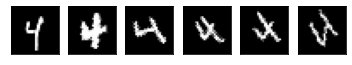

In [29]:
import matplotlib.pyplot as plt
plt.gray()
for i, f in enumerate(fours):
    plt.subplot(1, 6, i+1)
    plt.imshow(f)
    plt.xticks([])
    plt.yticks([])
plt.show()